# Install, Paths and Parameters

In [36]:
import os
from pathlib import Path
import getpass
import numpy as np
import pandas as pd
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
import torchattacks
from torchattacks import *
from tqdm import tqdm
import random
import sys

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
# from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino, ViTWrapper
from src.model.data import *
from src.model.train import *

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

DATA_PATH = Path('/','cluster', 'scratch', 'thobauma', 'dl_data')
MAX_PATH = Path('/','cluster', 'scratch', 'mmathys', 'dl_data')

LOG_BASE_PATH = Path(MAX_PATH, 'logs')

# DamageNet
DN_PATH = Path(DATA_PATH, 'damageNet')
DN_LABEL_PATH = Path(DN_PATH, 'val_damagenet.txt')
DN_IMAGES_PATH = Path(DN_PATH, 'images')

# Image Net
ORI_PATH = Path(DATA_PATH, 'ori_data')
CLASS_SUBSET_PATH = Path(ORI_PATH, 'class_subset.npy')

VAL_PATH = Path(ORI_PATH, 'validation')
VAL_IMAGES_PATH = Path(VAL_PATH,'images')
VAL_LABEL_PATH = Path(VAL_PATH, 'correct_labels.txt')

TRAIN_PATH = Path(ORI_PATH, 'train')
TRAIN_IMAGES_PATH = Path(TRAIN_PATH,'images')
TRAIN_LABEL_PATH = Path(TRAIN_PATH, 'correct_labels.txt')

In [37]:
# If CLASS_SUBSET is specified, INDEX_SUBSET will be ignored. Set CLASS_SUBSET=None if you want to use indexes.
# INDEX_SUBSET = get_random_indexes(number_of_images = 50000, n_samples=1000)
# CLASS_SUBSET = get_random_classes(number_of_classes = 10, min_rand_class = 1, max_rand_class = 1001)


CLASS_SUBSET = np.load(CLASS_SUBSET_PATH)
CLASS_SUBSET = CLASS_SUBSET[:3]


NUM_WORKERS= 0
PIN_MEMORY=True

BATCH_SIZE = 32

DEVICE = 'cuda'

In [38]:
CLASS_SUBSET

array([103, 436, 861])

In [39]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit([i for i in CLASS_SUBSET])

LabelEncoder()

# Load data

In [40]:
# Remember to set the correct transformation

train_dataset = AdvTrainingImageDataset(TRAIN_IMAGES_PATH, TRAIN_LABEL_PATH, ADVERSARIAL_TRAINING_TRANSFORM, CLASS_SUBSET, index_subset=None, label_encoder=label_encoder)
val_dataset = AdvTrainingImageDataset(VAL_IMAGES_PATH, VAL_LABEL_PATH, ORIGINAL_TRANSFORM, CLASS_SUBSET, index_subset=None, label_encoder=label_encoder)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False)

print(f'train:      {len(train_dataset)}\nvalidation:  {len(val_dataset)}')

train:      3872
validation:  150


# Get Model, Classifier
Official repo: https://github.com/facebookresearch/dino

In [41]:
model, base_linear_classifier = get_dino()

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_small built.
Embed dim 1536
We load the reference pretrained linear weights from dino_deitsmall16_pretrain/dino_deitsmall16_linearweights.pth.


In [42]:
base_linear_classifier

LinearClassifier(
  (linear): Linear(in_features=1536, out_features=1000, bias=True)
)

In [43]:
class BaseLinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""
    def __init__(self, dim, num_labels=1000):
        super(BaseLinearClassifier, self).__init__()
        self.num_labels = num_labels
        self.linear = nn.Linear(dim, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        return self.linear(x)

In [44]:
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""
    def _init_(self, dim, num_labels=1000, hidden_size=512):
        super(LinearClassifier, self)._init_()
        self.num_labels = num_labels
        
        self.linear1 = nn.Linear(dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, int(hidden_size / 2))
        self.linear3 = nn.Linear(int(hidden_size / 2), int(hidden_size / 4))
        self.linear4 = nn.Linear(int(hidden_size / 4), num_labels)
#         self.linear.weight.data.normal_(mean=0.0, std=0.01)
#         self.linear.bias.data.zero_()
#         self.linear2.weight.data.normal_(mean=0.0, std=0.01)
#         self.linear2.bias.data.zero_()
#         self.initialize()

        self.relu = nn.ReLU()
    
    def initialize(self):
        nn.init.normal_(self.linear1.weight, mean=0, std=1.0)
        nn.init.normal_(self.linear1.bias, mean=0, std=1.0)
        nn.init.normal_(self.linear2.weight, mean=0, std=1.0)
        nn.init.normal_(self.linear2.bias, mean=0, std=1.0)
        nn.init.normal_(self.linear3.weight, mean=0, std=1.0)
        nn.init.normal_(self.linear3.bias, mean=0, std=1.0)
        nn.init.normal_(self.linear4.weight, mean=0, std=1.0)
        nn.init.normal_(self.linear4.bias, mean=0, std=1.0)
        # nn.init.xavier_uniform(self.linear.weight.data)
        # self.linear.bias.data.zero_()

    def forward(self, x):
        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        
        return self.linear4(x)

# Sanity Check

In [20]:
n_classifier = LinearClassifier(base_linear_classifier.linear.in_features, num_labels=len(CLASS_SUBSET))
n_classifier = n_classifier.cuda()

In [26]:
LOG_PATH = Path(LOG_BASE_PATH, 'original_javi')
os.makedirs(LOG_PATH)

In [27]:
n_loggers = train(model, 
                n_classifier,
                train_loader,
                val_loader, 
                LOG_PATH, 
                epochs=4,
#                adversarial_attack=train_attack
               )

Epoch: [0]  [ 0/49]  eta: 0:00:46  lr: 0.000063  loss: 0.942582 (0.942582)  time: 0.958765  data: 0.740540  max mem: 6922
Epoch: [0]  [20/49]  eta: 0:00:25  lr: 0.000063  loss: 0.836778 (0.845048)  time: 0.892032  data: 0.747926  max mem: 6922
Epoch: [0]  [40/49]  eta: 0:00:07  lr: 0.000063  loss: 0.491736 (0.676853)  time: 0.878587  data: 0.735228  max mem: 6922
Epoch: [0]  [48/49]  eta: 0:00:00  lr: 0.000063  loss: 0.417293 (0.622969)  time: 0.846109  data: 0.707655  max mem: 6922
Epoch: [0] Total time: 0:00:42 (0.874033 s / it)
Averaged stats: lr: 0.000063  loss: 0.417293 (0.622969)
Test:  [0/2]  eta: 0:00:02  loss: 0.312232 (0.312232)  acc1: 98.750000 (98.750000)  time: 1.039206  data: 0.869246  max mem: 6922
Test:  [1/2]  eta: 0:00:00  loss: 0.312232 (0.321314)  acc1: 98.571426 (98.666666)  time: 0.964880  data: 0.817275  max mem: 6922
Test: Total time: 0:00:01 (0.965542 s / it)
* Acc@1 98.667 loss 0.321
Accuracy at epoch 0 of the network on the 150 test images: 98.7%
Max accuracy

# PGD

In [45]:
pgd_classifier = LinearClassifier(base_linear_classifier.linear.in_features, num_labels=len(CLASS_SUBSET), hidden_size=2048).cuda()

In [46]:
vits = ViTWrapper(model, pgd_classifier)

In [47]:
# Define attack used for adversarial training
train_attack = PGD(vits, eps=0.03, alpha=2/255, steps=15)

In [48]:
LOG_PATH = Path(LOG_BASE_PATH, 'pgd', '03_javi')
os.makedirs(LOG_PATH, exist_ok=True)

Epoch: [0]  [  0/121]  eta: 0:05:17  lr: 0.000063  loss: 2.429768 (2.429768)  time: 2.626067  data: 0.650625  max mem: 7308
Epoch: [0]  [ 20/121]  eta: 0:04:28  lr: 0.000063  loss: 2.196653 (2.232653)  time: 2.656971  data: 0.714337  max mem: 7308
Epoch: [0]  [ 40/121]  eta: 0:03:36  lr: 0.000063  loss: 1.831438 (2.040052)  time: 2.692101  data: 0.736012  max mem: 7308
Epoch: [0]  [ 60/121]  eta: 0:02:45  lr: 0.000063  loss: 1.672182 (1.922293)  time: 2.779036  data: 0.820394  max mem: 7308
Epoch: [0]  [ 80/121]  eta: 0:01:52  lr: 0.000063  loss: 1.606984 (1.844523)  time: 2.840923  data: 0.881913  max mem: 7308
Epoch: [0]  [100/121]  eta: 0:00:57  lr: 0.000063  loss: 1.554809 (1.787137)  time: 2.806965  data: 0.847888  max mem: 7308
Epoch: [0]  [120/121]  eta: 0:00:02  lr: 0.000063  loss: 1.515684 (1.742247)  time: 2.841132  data: 0.882953  max mem: 7308
Epoch: [0] Total time: 0:05:34 (2.768402 s / it)
Averaged stats: lr: 0.000063  loss: 1.515684 (1.742247)


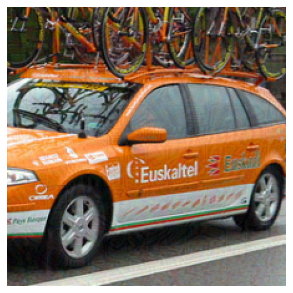

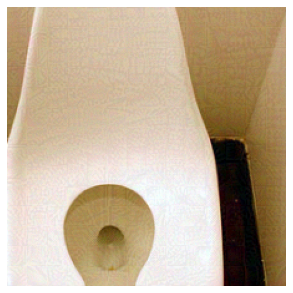

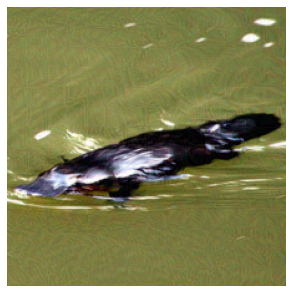

Test:  [0/5]  eta: 0:00:14  loss: 0.989350 (0.989350)  acc1: 93.750000 (93.750000)  adv_loss: 1.479801 (1.479801)  adv_acc1: 0.000000 (0.000000)  time: 2.920777  data: 0.919336  max mem: 7308
Test:  [4/5]  eta: 0:00:02  loss: 0.996658 (0.994756)  acc1: 95.454552 (96.000001)  adv_loss: 1.487475 (1.488364)  adv_acc1: 0.000000 (0.000000)  time: 2.821808  data: 0.906624  max mem: 7308
Test: Total time: 0:00:14 (2.822078 s / it)
* Acc@1 96.000 loss 0.995
* adv_Acc@1 0.000 adv_loss 1.488
Accuracy at epoch 0 of the network on the 150 test images: 96.0%
Max accuracy so far: 96.00%
Epoch: [1]  [  0/121]  eta: 0:05:02  lr: 0.000057  loss: 1.460065 (1.460065)  time: 2.498430  data: 0.540216  max mem: 7308


KeyboardInterrupt: 

In [49]:
loggers = train(model, 
                pgd_classifier,
                train_loader,
                val_loader, 
                LOG_PATH, 
                epochs=5,
                adversarial_attack=train_attack,
                show_image=True
               )

In [11]:
validation_attack = PGD(vits, eps=0.6, alpha=2/255, steps=15)

In [14]:
log_dict, logs = validate_network(model, 
                linear_classifier, 
                val_loader,
                tensor_dir=None,
                adversarial_attack=validation_attack)

Test:  [ 0/10]  eta: 0:00:13  loss: 0.094194 (0.094194)  acc1: 100.000000 (100.000000)  time: 1.385940  data: 0.230570  max mem: 1422
Test:  [ 9/10]  eta: 0:00:01  loss: 0.098080 (0.105388)  acc1: 100.000000 (99.333333)  time: 1.242715  data: 0.197191  max mem: 1422
Test: Total time: 0:00:12 (1.242903 s / it)
* Acc@1 99.333 loss 0.105


In [50]:
LOG_PATH

PosixPath('/cluster/scratch/mmathys/dl_data/logs/pgd/03_javi')

# Plotting

In [17]:
inp, target, name = next(iter(val_loader))

In [18]:
inp = inp.cuda(non_blocking=True)
target = target.cuda(non_blocking=True)
out = train_attack(inp, target)

In [19]:
import matplotlib.pyplot as plt

def imshow(img, title):
    img = img.to('cpu')
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

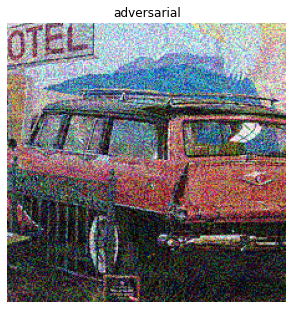

In [20]:
imshow(out[0], 'adversarial')

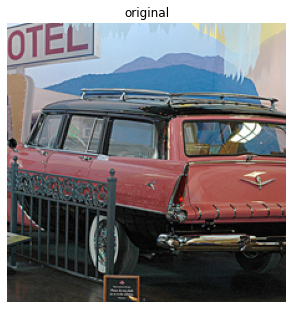

In [21]:
imshow(inp[0], 'original')

In [27]:
log_dict, logs = validate_network(model, 
                linear_classifier, 
                val_loader,
                tensor_dir=None,
                adversarial_attack=train_attack)

Test:  [ 0/10]  eta: 0:00:14  loss: 1.091493 (1.091493)  acc1: 50.000000 (50.000000)  adv_loss: 1.106042 (1.106042)  adv_acc1: 0.000000 (0.000000)  time: 1.487029  data: 0.270818  max mem: 1456
Test:  [ 9/10]  eta: 0:00:01  loss: 1.095770 (1.097160)  acc1: 50.000000 (50.666667)  adv_loss: 1.112605 (1.113430)  adv_acc1: 0.000000 (0.666667)  time: 1.315169  data: 0.228885  max mem: 1456
Test: Total time: 0:00:13 (1.315430 s / it)
* Acc@1 50.667 loss 1.097
* adv_Acc@1 0.667 adv_loss 1.113
